# Investigating Fandango Movie Ratings

Fandango Media, LLC is an American ticketing company that sells movie tickets via their website as well as through their mobile app. Users can also rate the movies on the platform.

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (Fandango is an online movie ratings aggregator). He published his analysis in this article — a great piece of data journalism that's totally worth reading.

Fandango displays a 5-star rating system on their website, where the minimum rating is 0 stars and the maximum is 5 stars.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

* The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
* In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
* For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.

![lineplot](img.png "Source:FiveThirtyEight")

Both distributions above are strongly left skewed, suggesting that movie ratings on Fandango are generally high or very high. We can see there's no rating under 2 stars in the sample Hickey analyzed. The distribution of displayed ratings is clearly shifted to the right compared to the actual rating distribution, suggesting strongly that Fandango inflates the ratings under the hood.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

In [78]:
import pandas as pd
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline
import re
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

## Understanding the Data

One of the best ways to figure out whether there has been any change in Fandango's rating system after Hickey's analysis is to compare the system's characteristics previous and after the analysis. Fortunately, we have ready-made data for both these periods of time:

* Walt Hickey made the data he analyzed publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

* One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available on [GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

In [4]:
movies_comparison_before=pd.read_csv('fandango_score_comparison.csv')
movies_comparison_after=pd.read_csv('movie_ratings_16_17.csv')

In [5]:
movies_comparison_before.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [6]:
movies_comparison_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
FILM                          146 non-null object
RottenTomatoes                146 non-null int64
RottenTomatoes_User           146 non-null int64
Metacritic                    146 non-null int64
Metacritic_User               146 non-null float64
IMDB                          146 non-null float64
Fandango_Stars                146 non-null float64
Fandango_Ratingvalue          146 non-null float64
RT_norm                       146 non-null float64
RT_user_norm                  146 non-null float64
Metacritic_norm               146 non-null float64
Metacritic_user_nom           146 non-null float64
IMDB_norm                     146 non-null float64
RT_norm_round                 146 non-null float64
RT_user_norm_round            146 non-null float64
Metacritic_norm_round         146 non-null float64
Metacritic_user_norm_round    146 non-null float64
IMDB_norm_round               146 n

In [7]:
movies_comparison_after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


In [8]:
movies_comparison_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
movie           214 non-null object
year            214 non-null int64
metascore       214 non-null int64
imdb            214 non-null float64
tmeter          214 non-null int64
audience        214 non-null int64
fandango        214 non-null float64
n_metascore     214 non-null float64
n_imdb          214 non-null float64
n_tmeter        214 non-null float64
n_audience      214 non-null float64
nr_metascore    214 non-null float64
nr_imdb         214 non-null float64
nr_tmeter       214 non-null float64
nr_audience     214 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


We will isolate the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in more readily available for later use.

In [9]:
fandango_before=movies_comparison_before[['FILM','Fandango_Stars','Fandango_Ratingvalue','Fandango_votes','Fandango_Difference']]
fandango_after=movies_comparison_after[['movie','year','fandango']]

The ideal population for our goal would be all movies on Fandango's website sampled at two different points in time: Before and after Hickey's analysis.

However, both datasets are samples. 

From Hickey's article and from the README.md of the data set's repository, we can see that he used the following sampling criteria:

* The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
* The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

* The movie must have been released in 2016 or later.
* The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).

This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

## Changing the Goal of our Analysis

It is quasi-impossible to collect a new sample previous to Hickey's analysis at this moment in time. So we will keep the data and place some limitations on our goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to find out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should be a good proxy to our initial goal.

## Isolating the Samples We Need

Some movies were not released in 2015 and 2016. So we will isolate the sample points that belong to our populations of interest.

Hickey's dataset has movies released in 2014 and 2015.

In [16]:
fandango_before['FILM'].str.contains(r'(\(2015\))').sum()

129

In [17]:
fandango_before['FILM'].str.contains(r'(\(2014\))').sum()

17

In [19]:
fandango_before.shape # All movies were either released in 2014 or 2015

(146, 5)

The second dataset has movies released in 2016 and 2017.

In [20]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [21]:
movies_2015=fandango_before[fandango_before['FILM'].str.contains(r'(\(2015\))')]
movies_2016=fandango_after[fandango_after['year']==2016]

## Comparing Distribution Shapes for 2015 and 2016


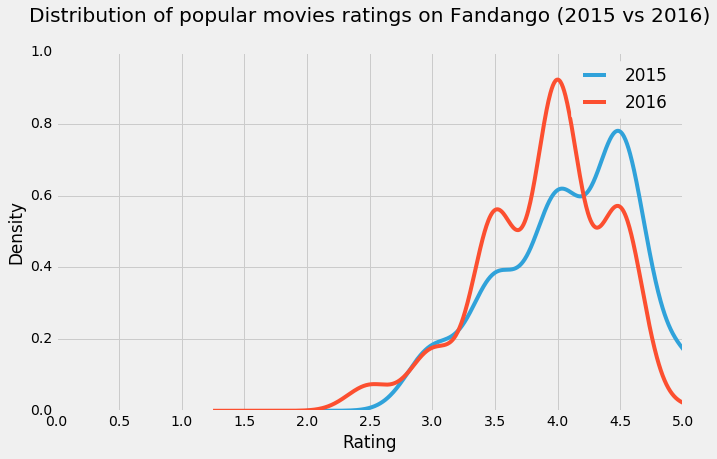

In [50]:
plt.style.use('fivethirtyeight')
movies_2015['Fandango_Stars'].plot.kde(figsize=(10,6),label="2015",legend=True)
movies_2016['fandango'].plot.kde(label='2016',legend=True)
plt.xlim(0,5)
plt.xlabel('Rating')
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.title('Distribution of popular movies ratings on Fandango (2015 vs 2016)',y=1.07)

We can observe that both distributions are strongly left-skewed, although the peak of 2015's rating distribution is slightly shifted to the right compared to 2016.

The left shift of 2016's ratings are interesting. It indicates that compared to 2015, most movies had a slightly lower rating: In 2015 most movies were rated around 4.5, but this number fell to 4.0 in 2016.

## Comparing Relative Frequencies

We will observe the frequency distribution tables of the two distributions. However the samples do not have the same number of movies:

In [54]:
movies_2015.shape

(129, 5)

In [56]:
movies_2016.shape

(191, 3)

It would make more sense if we used relative frequencies.

In [58]:
(100*movies_2015['Fandango_Stars'].value_counts().sort_index()/movies_2015.shape[0]).round(2)

3.0     8.53
3.5    17.83
4.0    28.68
4.5    37.98
5.0     6.98
Name: Fandango_Stars, dtype: float64

In [59]:
(100*movies_2016['fandango'].value_counts().sort_index()/movies_2016.shape[0]).round(2)

2.5     3.14
3.0     7.33
3.5    24.08
4.0    40.31
4.5    24.61
5.0     0.52
Name: fandango, dtype: float64

In 2015, most movies had a very high rating of 4.5 stars (38%) and 7% percent had a perfect rating of 5 stars. However, in 2016 most movies had a rating of 4 stars (40%) and only 0.52% of the movies had a perfect score. In fact, the minimum rating changed from 3 stars in 2015 to 2.5 stars in 2016.

On the other hand, most ratings had a decrease in percentage relative to 2015. But the percentage increased for the 3.5 and 4 stars. The direction of the difference is not very clear, although it still indicates a change in the distributions.

## Determining the Direction of the Change

We confirmed with the two tables before that there is indeed a clear difference between the two distributions. However, the direction of the difference is not as clear as it was on the kernel density plots.

We'll take a couple of summary statistics to get a more precise picture about the direction of the difference. We'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [72]:
mean_2015=movies_2015['Fandango_Stars'].mean()
median_2015=movies_2015['Fandango_Stars'].median()
mode_2015=movies_2015['Fandango_Stars'].mode()[0]

mean_2016=movies_2016['fandango'].mean()
median_2016=movies_2016['fandango'].median()
mode_2016=movies_2016['fandango'].mode()[0]

stats=pd.DataFrame([])
stats['2015']=[mean_2015,median_2015,mode_2015]
stats['2016']=[mean_2016,median_2016,mode_2016]
stats.index=['mean','median','mode']

In [73]:
stats

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


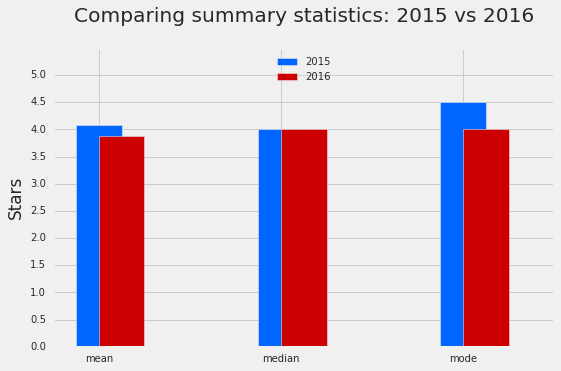

In [79]:
plt.style.use('fivethirtyeight')
stats['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
stats['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

## Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.